# CH4 Time Series Modeling
**Objective**: Develop a SARIMA model for forecasting atmospheric methane concentration

## Input Data
'data/processed/all_ghg_aligned_nan.csv'

## Stages
1. train/test split
2. test data transformations (log and differencing)
3. Auto-ARIMA parameter search
4. SARIMA model selection

In [131]:
# enable auto-reloading of imported modules
%load_ext autoreload
%autoreload 2

# ensure src/imports work
import sys
sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Libraries

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import boxcox 
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan, het_white, het_arch

from src.preprocessing import GasPreprocessor
from src.forecast_metrics import forecast_metrics
from src.model_evaluation import evaluate_sarima_model
print('GasPreprocessor imported successfully!')
print('forecast_metrics imported successfully!')
print('model_evaluation imported successfully!')

GasPreprocessor imported successfully!
forecast_metrics imported successfully!
model_evaluation imported successfully!


# Load the Data

In [133]:
df_combined = pd.read_csv('../data/processed/all_ghg_aligned_nan.csv',
                          parse_dates=['date'], index_col='date')

In [134]:
df_combined['CH4'].head()

date
1969-08-20   NaN
1969-08-27   NaN
1969-09-02   NaN
1969-09-12   NaN
1969-09-24   NaN
Name: CH4, dtype: float64

In [135]:
df_combined['CH4'].tail(10)

date
2024-12-24    1952.380
2024-12-31    1977.445
2025-01-03         NaN
2025-01-07         NaN
2025-01-14         NaN
2025-01-21         NaN
2025-01-29         NaN
2025-02-11         NaN
2025-02-25         NaN
2025-04-03         NaN
Name: CH4, dtype: float64

In [136]:
# determine the first and last valid index for the CH4 series.  
# Note: df_combined is a concatenated and pivoted dataframe of 6 greenhouse gases that were aligned based on 
# data collection date.  So, there will certainly be missing values at the beginning of 5 of the 6 gas data series.  

print("First CH4 data point:", df_combined['CH4'].first_valid_index())
print("Last CH4 data point:", df_combined['CH4'].last_valid_index())
print("\nInitial gap duration:", df_combined['CH4'].first_valid_index() - df_combined['CH4'].index[0])
print("End gap duration:", df_combined['CH4'].index[-1] - df_combined['CH4'].last_valid_index())

First CH4 data point: 1983-05-06 00:00:00
Last CH4 data point: 2024-12-31 00:00:00

Initial gap duration: 5007 days 00:00:00
End gap duration: 93 days 00:00:00


**NOTE:** The GasPreprocessor class has methods to trim the initial and trailing NaNs.  However, an accurate train/test split is more dependent on trailing NaNs since they would be further trimmed during preprocessed by the GasPreprocessor class resulting in a smaller test set than expected.  So, I will trim the trailing NaNs prior to train/test split.  

# Split the Data Into Training and Testing Sets

In [138]:
# Trim trailing NaNs prior to train/test split

def trim_trailing_nans(series):
    '''
    Trim trailing NaN values from a series.
    '''
    last_valid_idx = series.last_valid_index()
    if last_valid_idx is not None and last_valid_idx < series.index[-1]:
        print(f'Trimming {len(series.loc[last_valid_idx:]) - 1} trailing NaN values from the raw series')
        return series.loc[:last_valid_idx]
    return series

In [141]:
# create CH4 series with trimmed trailing NaNs

ch4_clean = trim_trailing_nans(df_combined['CH4'])
ch4_clean_df = ch4_clean.reset_index() # convert back to DataFrame with date column

print(f'CH4 raw data: {len(df_combined['CH4'])} points, from {df_combined['CH4'].index.min()} to {df_combined['CH4'].index.max()}')
print(f'CH4 raw data trimmed of trailing NaNs: {len(ch4_clean)} points, from {ch4_clean.index.min()} to {ch4_clean.index.max()}')

Trimming 8 trailing NaN values from the raw series
CH4 raw data: 2562 points, from 1969-08-20 00:00:00 to 2025-04-03 00:00:00
CH4 raw data trimmed of trailing NaNs: 2554 points, from 1969-08-20 00:00:00 to 2024-12-31 00:00:00


In [142]:
test_size = 52 # one year of weekly data

CH4_train = ch4_clean.iloc[:-test_size]
CH4_test = ch4_clean.iloc[-test_size:]

print(f'Train data: {CH4_train.shape[0]} data points, from {CH4_train.index.min()} to {CH4_train.index.max()}')
print(f'Test data: {CH4_test.shape[0]} data points, from {CH4_test.index.min()} to {CH4_test.index.max()}')

Train data: 2502 data points, from 1969-08-20 00:00:00 to 2023-10-17 00:00:00
Test data: 52 data points, from 2023-10-24 00:00:00 to 2024-12-31 00:00:00


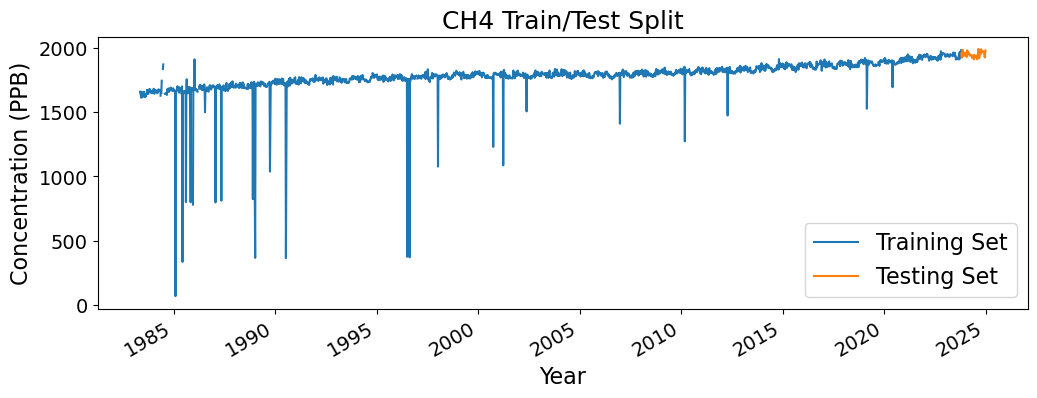

In [144]:
# visually confirm the data split

fig, ax = plt.subplots(figsize=(12,4))
CH4_train.plot(ax=ax, label='Training Set')
CH4_test.plot(ax=ax, label='Testing Set')

ax.legend(fontsize=16)
ax.set_title('CH4 Train/Test Split', fontsize=18)
ax.set_ylabel('Concentration (PPB)', fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax.tick_params(axis='both', labelsize=14)
plt.show()

## Proprocessing and EDA of CH4 Train Set

In [145]:
# reset index to make 'date' column

CH4_train_with_date = CH4_train.reset_index()
CH4_test_with_date = CH4_test.reset_index()


[INFO] Fitting preprocessing for CH4
Trimming 388 leading NaN values
Raw data: 2502 points, 432 NaNs
Trimmed data: 2114 points, 44 NaNs
Data range after trimming: 1983-05-06 00:00:00 to 2023-10-17 00:00:00
After resampling: 2112 points, 67 NaNs
[INFO] Found 150 potential outliers using robust STL residuals.
After outlier removal: 2112 points, 217 NaNs
After smoothing: 2112 points, 1 NaNs
After interpolation: 2112 points, 0 NaNs


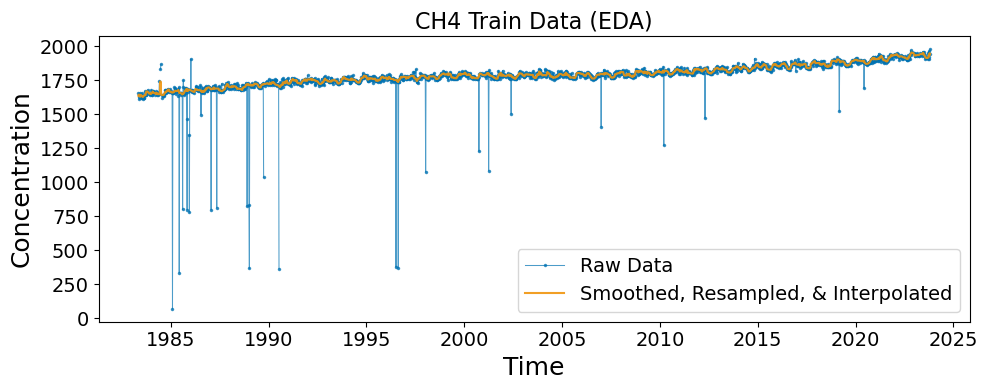

[INFO] EDA stationarity tests on processed data:
ADF and KPSS tests for Processed Data:
ADF statistic -1.0139
ADF p-value 0.7481
ADF critical values: {'1%': -3.433479704613104, '5%': -2.8629225683793083, '10%': -2.5675060146913125}

KPSS statistic 6.6953
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the Processed Data time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:407: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  


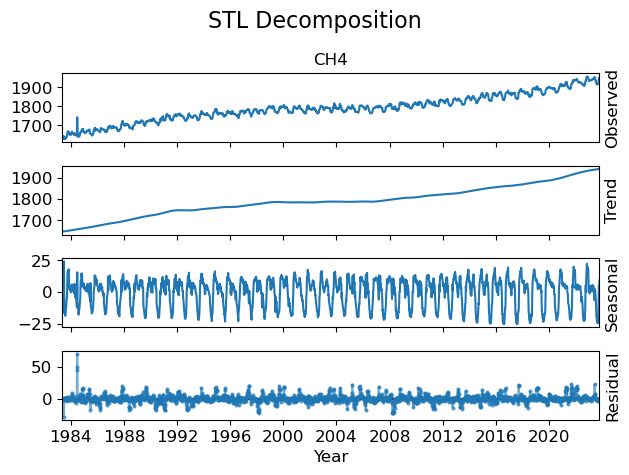

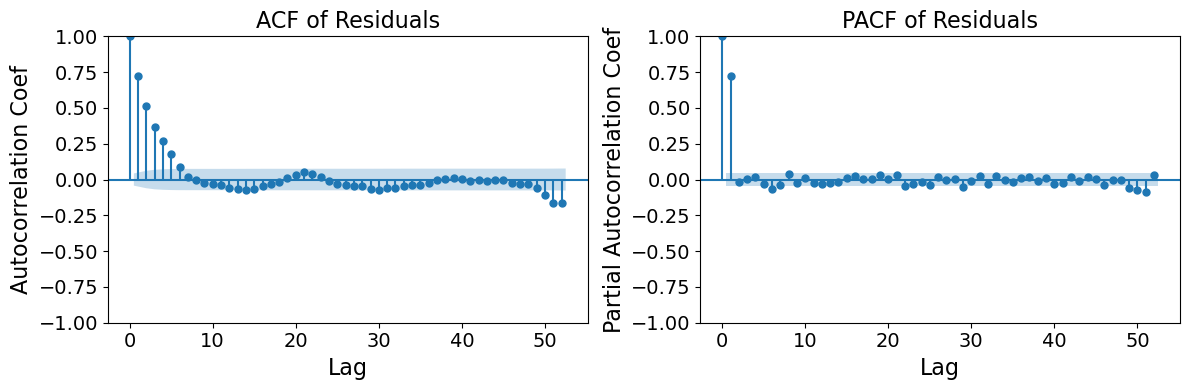


Heteroscedasticity Tests of Residuals
Breusch-Pagan p-value: 0.0196
Heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.0028
Heteroscedasticity detected (White test)
Trimming 388 leading NaN values


In [146]:
# fit and transform the training data to the GasPreprocessor class
# transform the test data using the fitted preprocessor

CH4_train_preprocessor = GasPreprocessor(gas_name='CH4', do_eda=True)
CH4_train_preprocessed = CH4_train_preprocessor.fit_transform(
    CH4_train_with_date, 
    custom_title = 'CH4 Train Data (EDA)'
)

# transform the test data using the fitted preprocessor
CH4_test_preprocessed = CH4_train_preprocessor.transform(CH4_test_with_date)

**Interpretation of the CH4 train series preprocessing and EDA**

Preprocessing the CH4 data appears to be effectively handling negative values, NaNs, and outliers while preserving the seasonality and trend.  The ADF and KPSS tests confirm that the data series is not stationary.  

STL decomposition provides visual confirmation of the positive trend and the regular, annual seasonality of atomospheric CH4 concentration.  The residuals are analyzed with the ACF and PACF plots.  

The ACF plot has significant spikes at lags 1-5 (not including the first lag (lag 0)) and oscillating behavior.  This suggests that autocorrelation exists in the training set after preprocessing.  Also notable are the significance of lags around 52 indicating seasonal autocorrelation.  

The gradual tapering down of significan lags in the ACF plot and the sharp cut off after lag 1 in the PACF plot suggest an AR(p) model, possibly AR(1).  

The ADF and KPSS results show that the residuals confirm that the data series is non-stationary, supporting the observation of a positive trend.  Non-seasonal differencing may be necessary.  

Heteroscedasticity - both the Breusch-Pagan and White tests indicate heteroscedasticity in the CH4 train set residuals.  So, log or Box-Cox transformation will likely be necessary.  

In [147]:
print('CH4_train shape:', CH4_train_with_date.shape)
print('CH4_test shape:', CH4_test_with_date.shape)

print('CH4_train_preprocessed shape:', CH4_train_preprocessed.shape)
print('CH4_test_preprocessed shape:', CH4_test_preprocessed.shape)

CH4_train shape: (2502, 2)
CH4_test shape: (52, 2)
CH4_train_preprocessed shape: (2111,)
CH4_test_preprocessed shape: (62,)


The difference in numbers of observations is due to resampling (performed by the Preprocessor class).  

the lengths of the split datasets after preprocessing, specifically due to weekly resampling, reflect their actual time spans, not just the number of data points:

Train: 2111 weeks (2111 weeks / 52 weeks/year = 40.6 years)
Test: 62 weeks (62 weeks / 52 weeks/year = 1.2 years)
The sum of weeks = 2173, which is 41.8 years. The full CH4 data series spans 1983-2025, which is ~42 years.

# Save the Preprocessed Train and Test data

In [148]:
from pathlib import Path

# define output path
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True, parents=True)

In [149]:
# save the preprocessed train data
output_path = output_dir / 'ch4_train_preprocessed.csv'
(
    CH4_train_preprocessed
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

# save the preprocessed test data
output_path = output_dir / 'ch4_test_preprocessed.csv'
(
    CH4_test_preprocessed
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

print(f'CH4_train_preprocessed data saved to:\n{output_path}')
print(f'Shape: {CH4_train_preprocessed.shape}')
print(f'\nCH4_test_preprocessed data saved to:\n{output_path}')
print(f'Shape: {CH4_test_preprocessed.shape}')

CH4_train_preprocessed data saved to:
..\data\processed\ch4_test_preprocessed.csv
Shape: (2111,)

CH4_test_preprocessed data saved to:
..\data\processed\ch4_test_preprocessed.csv
Shape: (62,)


# Preprocessing With Log Transformation


[INFO] Fitting preprocessing for CH4
Trimming 388 leading NaN values
Raw data: 2502 points, 432 NaNs
Trimmed data: 2114 points, 44 NaNs
Data range after trimming: 1983-05-06 00:00:00 to 2023-10-17 00:00:00
[INFO] Applying log transformation.
After resampling: 2112 points, 67 NaNs
[INFO] Found 148 potential outliers using robust STL residuals.
After outlier removal: 2112 points, 215 NaNs
After smoothing: 2112 points, 0 NaNs
After interpolation: 2112 points, 0 NaNs


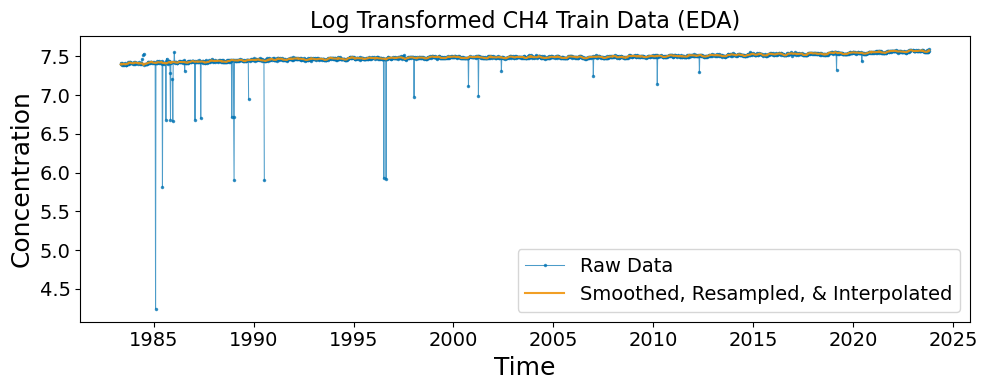

[INFO] EDA stationarity tests on processed data:
ADF and KPSS tests for Processed Data:
ADF statistic -0.9846
ADF p-value 0.7588
ADF critical values: {'1%': -3.433481203206757, '5%': -2.862923230045995, '10%': -2.5675063669901363}

KPSS statistic 6.6824
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the Processed Data time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:407: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  


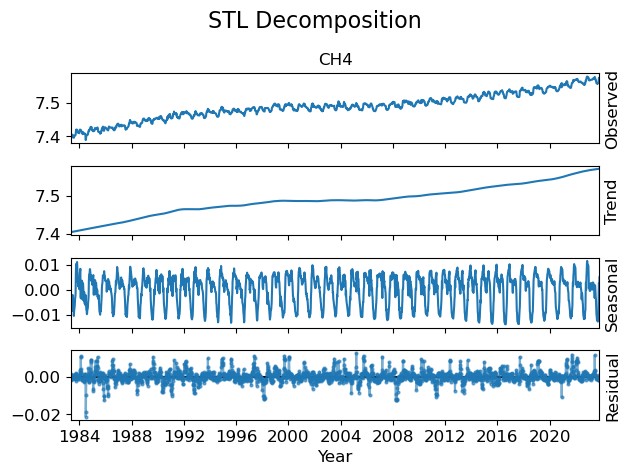

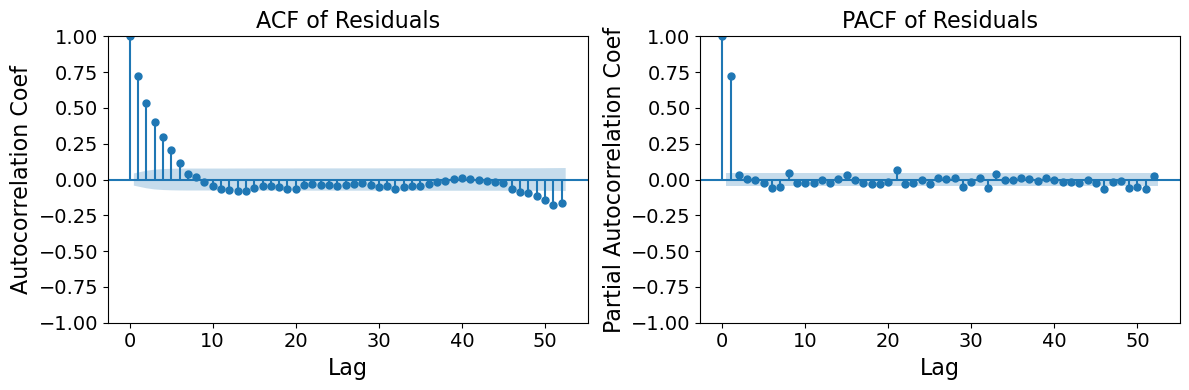


Heteroscedasticity Tests of Residuals
Breusch-Pagan p-value: 0.0126
Heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.0241
Heteroscedasticity detected (White test)
Trimming 388 leading NaN values


In [150]:
# fit and transform the training data to the GasPreprocessor class, including log transformation to handle heteroscedasticity
# transform the validation and test data using the fitted preprocessor

CH4_train_log_preprocessor = GasPreprocessor(gas_name='CH4', do_eda=True, transformation='log')
CH4_train_log_preprocessed = CH4_train_log_preprocessor.fit_transform(
    CH4_train_with_date, 
    custom_title = 'Log Transformed CH4 Train Data (EDA)'
)

# transform the test data using the fitted preprocessor
CH4_test_log_preprocessed = CH4_train_log_preprocessor.transform(CH4_test_with_date)

In [151]:
# verify data structure following transformation and preprocessing 

print('CH4_train shape:', CH4_train_with_date.shape)
print('CH4_test shape:', CH4_test_with_date.shape)

print('\nCH4_train_preprocessed shape:', CH4_train_preprocessed.shape)
print('CH4_test_preprocessed shape:', CH4_test_preprocessed.shape)

print('\nCH4_train_log_preprocessed shape:', CH4_train_log_preprocessed.shape)
print('CH4_test_log_preprocessed shape:', CH4_test_log_preprocessed.shape)

CH4_train shape: (2502, 2)
CH4_test shape: (52, 2)

CH4_train_preprocessed shape: (2111,)
CH4_test_preprocessed shape: (62,)

CH4_train_log_preprocessed shape: (2111,)
CH4_test_log_preprocessed shape: (62,)


**Comparison of Statistical Test Results Before and After Log Transformation of the Training Dataseries:**

- Non-transformed data:

    - ADF statistic: -1.0139, p-value: 0.7481

    - KPSS statistic: 6.6953, p-value: 0.0100

    - result:  the preprocessed data time series is non-stationary according to ADF and KPSS tests.

    - Breusch-Pagan p-value: 0.0196

    - White test p-value: 0.0028

    - result:  Both tests fail to reject the null hypotheses of heteroscedasticity (p < 0.05).

- Log-transformed data:

    - ADF statisti:c -0.9846, p-value: 0.7588

    - KPSS statistic: 6.6824, p-value: 0.0100

    - result:  the Processed Data time series is non-stationary according to ADF and KPSS tests.

    - Breusch-Pagan p-value: 0.0126

    - White test p-value: 0.0241

    - result:  Both tests fail to reject the null hypotheses of heteroscedasticity (p < 0.05).

Trend/Seasonality:

Log transformation did not affect stationarity, which is expected and will be addressed through differencing in the SARIMA model.

Heteroscedasticity

The log transformation helped slightly based on the White test result, but there is remaining variance in the residuals.

Autocorrelation patterns:

Prior to log transformation, the ACF plot of STL decomposition residuals shows an oscillatory behavior, which is greatly reduced after log transformation. This is an argument for log transformation since it simplifies the correlation structure and should help tune the SARIMA model orders.

Interpretation of ACF and PACF plots for SARIMA model orders:

The ACF plot shows a gradual decay in autocorrelation coefficient magnitude from lag 1 - 5 indicating non-stationarity requiring non-seasonal differencing. The strong spike at lag 1 in the PACF plot indicates first order differencing (d = 1). The significant lag at 52 is consistent with annual seasonality with weekly time points and suggests the need for seasonal differencing (D = 1).

The gradual decay of lags 1 - 5 of the ACF plot and sharp cut off after lag 1 on the PACF plot indicates an AR(1) process.

model suggestion (thus far): SARIMA(1,1,0)(0,1,0)52

# Difference Preprocessed/Log Transformed Train Data

Origninal series length: 2111
Non-seasonally differenced series length: 2110

[INFO] Stationarity tests on non-seasonally differenced series:
ADF and KPSS tests for non-seasonally differenced:
ADF statistic -15.3100
ADF p-value 0.0000
ADF critical values: {'1%': -3.433485707610957, '5%': -2.8629252188514385, '10%': -2.5675074259130812}

KPSS statistic 0.0534
KPSS p-value 0.1000
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the non-seasonally differenced time series is likely stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:407: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  


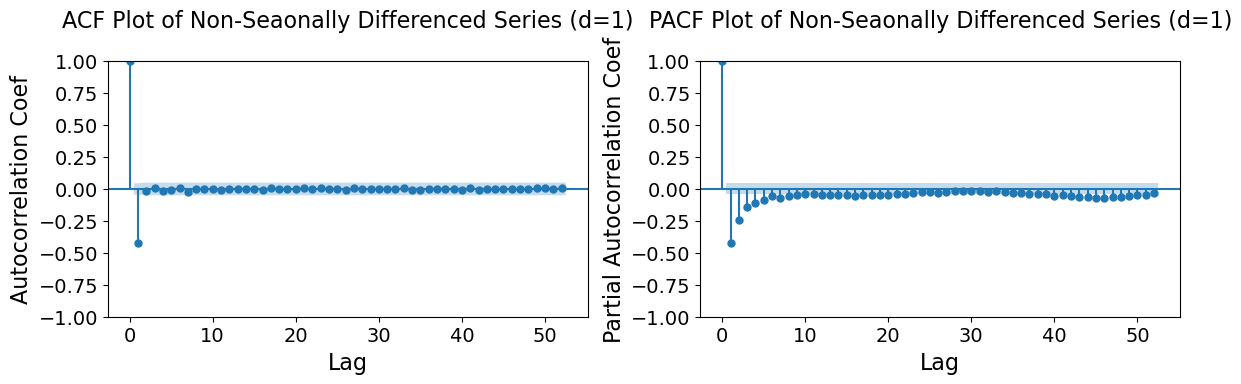

In [152]:
# I will first inspect the residuals of non-seasonally differenced log transformed train data to determine its effectiveness

nsdiffed_series = CH4_train_log_preprocessed.diff(1).dropna()

print(f'Origninal series length: {len(CH4_train_log_preprocessed)}')
print(f'Non-seasonally differenced series length: {len(nsdiffed_series)}')

# stationarity tests
print('\n[INFO] Stationarity tests on non-seasonally differenced series:')
CH4_train_log_preprocessor._run_stationarity_tests(nsdiffed_series, 'non-seasonally differenced')

# plot ACF and PACF
CH4_train_log_preprocessor.plot_acf_pacf(nsdiffed_series, 'Non-Seaonally Differenced Series (d=1)')

**Interpretation of non-seasonal differencing**

After non-seasonal differencing (d = 1), the log transformed and preprocessed train data is now stationary according to both the ADF and KPSS tests.  

ACF and PACF plot results:  The gradual decay seen in the PACF plot along with the sharp cut off observed in the ACF plot indicates an MA process.  

ACF plot results:  One significant lag with sharp cutoff corroborates the ADF and KPSS test results that there is no remaining autocorrelation.  The single spike suggests an MA term, q = 1 for the non-seasonal component.  

PACF plot results:  Apparently the gradual decay is typical after differencing, though an AR term (AR(1)) might help.

Another important observation is that lags around 52 are no longer significant.  Seasonal differencing may not be necessary but will test its affect.  

Thus far:  p = 0 or 1, d = 1, q = 1


[INFO]: Stationarity tests on seasonally differenced series (D=1 only):
ADF and KPSS tests for seasonally differenced (D=1):
ADF statistic -17.1282
ADF p-value 0.0000
ADF critical values: {'1%': -3.4335361251480934, '5%': -2.862947479232111, '10%': -2.5675192783016914}

KPSS statistic 0.3728
KPSS p-value 0.0889
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the seasonally differenced (D=1) time series is likely stationary according to ADF and KPSS tests.



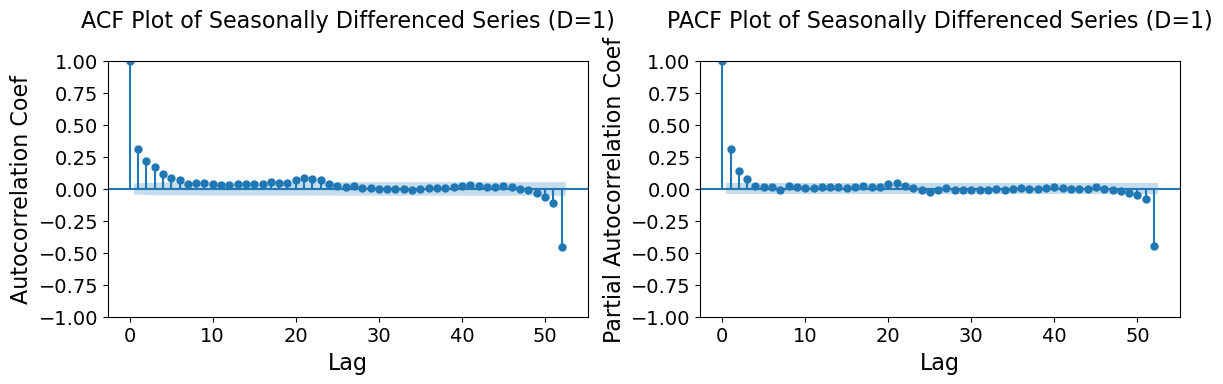

In [153]:
# Test the affect of only seasonal differencing (D=1)

# Apply only seasonal differencing (no non-seasonal)
sdiff = CH4_train_log_preprocessed.diff(52).dropna()

print('\n[INFO]: Stationarity tests on seasonally differenced series (D=1 only):')
CH4_train_log_preprocessor._run_stationarity_tests(sdiff, 'seasonally differenced (D=1)')

# Plot ACF/PACF
CH4_train_log_preprocessor.plot_acf_pacf(sdiff, 'Seasonally Differenced Series (D=1)')

**Interpretation of seasonal differencing**

Seasonal-only differencing also results in a stationary series.  However, the ACF and PACF plots are more complex compared to the non-seasonal-only differencing with gradual decay in both ACF and PACF non-seasonal lags as well as significant spikes at lag 52 (seasonal lag).  I will test the effects of combined non-seasonal and seasonal differening.  


[INFO]: Stationarity tests on non-seasonally and seasonally differenced series:
ADF and KPSS tests for non-seasonally & seasonally differenced:
ADF statistic -16.8363
ADF p-value 0.0000
ADF critical values: {'1%': -3.4335658957561157, '5%': -2.862960623392398, '10%': -2.567526276849711}

KPSS statistic 0.0458
KPSS p-value 0.1000
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the non-seasonally & seasonally differenced time series is likely stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:407: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  


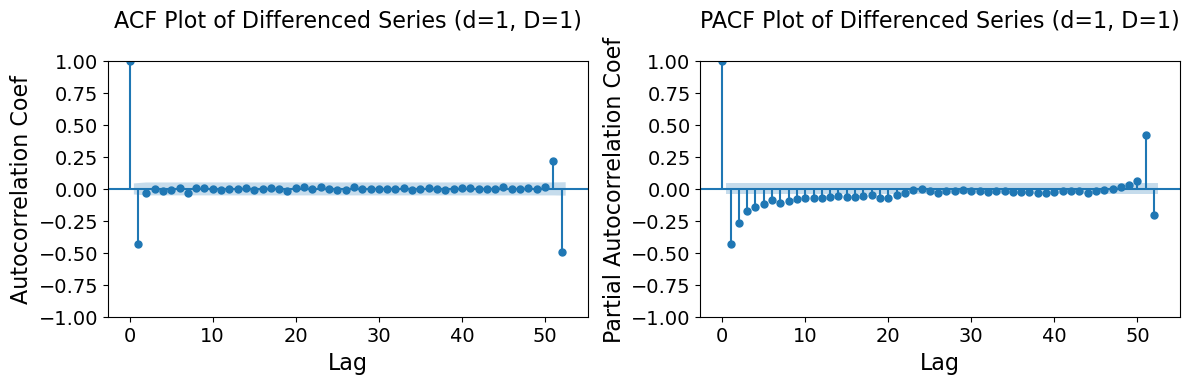

In [154]:
# Test the affect of non-seasonal and seasonal differencing (d=1, D=1)

snsdiffed_series = nsdiffed_series.diff(52).dropna()

# stationarity tests
print('\n[INFO]: Stationarity tests on non-seasonally and seasonally differenced series:')
CH4_train_log_preprocessor._run_stationarity_tests(snsdiffed_series, 'non-seasonally & seasonally differenced')

# ACF and PACF plots
CH4_train_log_preprocessor.plot_acf_pacf(snsdiffed_series, 'Differenced Series (d=1, D=1)')

**Interpretation of differencing results:**

The non-seasonal-only differencing (d=1) is stationary and has the cleanest ACF and PACF plots.  Seasonal differencing also leads to stationarity but the residuals show some memory in both ACF and PACF lags.  It also leads to a significant spike at lag 52 in both ACF and PACF plots.  The combination of both non-seasonal and seasonal differencing may be inducing some artifacts as observed by the significant spikes at both lags 51 and 52. Additionally, there is a more complex pattern of decay in early lags of the PACF plot.  

conclusion:  non-seasonal only differencing effectively handles the CH4 trend and is likely sufficient for effective modeling and suggests that the annual seasonal pattern is stable.  

Non-seasonal-only differencing interpretation: 
- The ACF has a significant negative spike only at lag 1, which suggests a non-seasonal MA(1) term (q=1).
- The PACF shows a gradual decay (negative) from lags 1 - 5, which indicates an AR process. However, the fact that the ACF cuts off after lag 1 (except for the seasonal lags) suggests simplicity and will consider AR terms 0,1, and possibly 2, though may be adequately modeled with an MA(1) term only.
- Neither ACF or PACF plots show a significant spike at lag 52 suggesting seasonal orders (P,D,Q) of 0,0,0 as initial estimates.    

Candidate models to begin with:
- SARIMA(1,1,1)(0,0,0)52 - simple model, non-seasonal only
- SARIMA(1,1,1)(1,0,1)52 - captures both seasonal AR and MA
- SARIMA(0,1,1)(1,0,1)52 - non-seasonal MA only
- SARIMA(1,1,0)(1,0,1)52 - non-seasonal AR only
- SARIMA(1,1,1)(0,0,1)52 - seasonal MA only
- SARIMA(1,1,1)(1,0,0)52 - seasonal AR only

# Auto-ARIMA of the preprocessed/log transformed CH4 train set series

In [155]:
# at this point, the differencing orders are likely best set at d=1, D=0.
# I will use Auto-Arima to search for the best SARIMA model orders (p,q, and P,Q)
# information criterion = 'aic'

print('Auto_Arima results for Preprocessed, Log-Transformed CH4 Train Data (AIC)\n')

stepwise_model_log_aic = auto_arima(
    CH4_train_log_preprocessed,
    start_p=0, start_q=0,
    max_p=2, max_q=2,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    seasonal=True,
    m=52,                  # weekly data
    d=None,
    D=None,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    information_criterion='aic',
    random_state=42,
    method='lbfgs'
)

print(stepwise_model_log_aic.summary())

Auto_Arima results for Preprocessed, Log-Transformed CH4 Train Data (AIC)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=-12639.402, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=-13059.830, Time=15.06 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=-13296.454, Time=61.32 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=-12641.311, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=-13292.915, Time=0.43 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=-13294.712, Time=67.26 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=-13297.490, Time=229.30 sec
 ARIMA(0,1,1)(1,0,2)[52] intercept   : AIC=-13295.699, Time=512.17 sec
 ARIMA(0,1,0)(0,0,2)[52] intercept   : AIC=-12635.238, Time=195.66 sec
 ARIMA(1,1,1)(0,0,2)[52] intercept   : AIC=-13319.259, Time=371.04 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=-13314.774, Time=100.11 sec
 ARIMA(1,1,1)(1,0,2)[52] intercept   : AIC=-13292.784, Time=256.09 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : 

In [156]:
# at this point, the differencing orders are likely best set at d=1, D=0.
# I will use Auto-Arima to search for the best SARIMA model orders (p,q, and P,Q)
# information criterion = 'bic'

print('Auto_Arima results for Preprocessed, Log-Transformed CH4 Train Data (BIC)\n')

stepwise_model_log_bic = auto_arima(
    CH4_train_log_preprocessed,
    start_p=0, start_q=0,
    max_p=2, max_q=2,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    seasonal=True,
    m=52,                  # weekly data
    d=None,
    D=None,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    information_criterion='bic',
    random_state=42,
    method='lbfgs'
)

print(stepwise_model_log_bic.summary())

Auto_Arima results for Preprocessed, Log-Transformed CH4 Train Data (BIC)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[52] intercept   : BIC=-12628.093, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : BIC=-13037.213, Time=14.08 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : BIC=-13273.836, Time=54.25 sec
 ARIMA(0,1,0)(0,0,0)[52]             : BIC=-12635.657, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : BIC=-13275.952, Time=0.44 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : BIC=-13274.272, Time=48.62 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : BIC=-13266.439, Time=58.87 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : BIC=-13284.954, Time=0.85 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : BIC=-13264.475, Time=50.83 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : BIC=-13286.502, Time=99.24 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : BIC=-13258.758, Time=77.02 sec
 ARIMA(1,1,1)(0,0,2)[52] intercept   : BIC=-13285.333, Time=371.69 sec
 ARIMA(1,1,1)(1,0,2)[52] intercept   : BIC=-1

# **Interpretation of the results for log transformed/preprocessed train data fit to Auto Arima:**

- AIC: Best model:  ARIMA(2,1,1)(0,0,1)[52] intercept
- BIC: Best model:  ARIMA(2,1,1)(0,0,1)[52] intercept

The auto-ARIMA algorithm with AIC and BIC converged on the same SARIMA model orders, shown above.  AIC favors best fit despite complexity, while BIC penalized complexity more heavily and favors a simpler model, therefore the agreement is a good indication of best model settings. All three non-seasonal terms (AR(L1), AR(L2), and MA(L1)), the one seasonal term (MA.S(L52)) and the intercept are all statistically significant.  Auto-ARIMA finds that one non-seasonal differencing (d = 1) and no seasonal differencing (D = 0) is optimal for both AIC and BIC, which corroborates the differencing tests performed above.  

Autocorrelation:  The Ljung-Box test null hypothesis is that the residuals are independently distributed, and therefore don't show autocorrelation.  

Heterscedasticity:  Both models show borderline statistically significant homoscedasticity (p = 0.06) in the fit residuals suggesting stable residual variance.   

Distribution of residuals:  The fit residuals are not normally distributed, which isn't ideal for SARIMA models. 


Heteroscedasticity Test for Log-Transformed CH4 Train Data
Breusch-Pagan p-value: 0.0000
Heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.0000
Heteroscedasticity detected (White test)

[INFO] Stationarity and Autocorrelation Analysis for Log-Transformed CH4 Train Data


C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:94: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


ADF and KPSS tests for Log-Transformed CH4 Train Data:
ADF statistic -1.3731
ADF p-value 0.5951
ADF critical values: {'1%': -3.43346628154387, '5%': -2.8629166417427734, '10%': -2.5675028591063254}

KPSS statistic 6.7533
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the Log-Transformed CH4 Train Data time series is non-stationary according to ADF and KPSS tests.



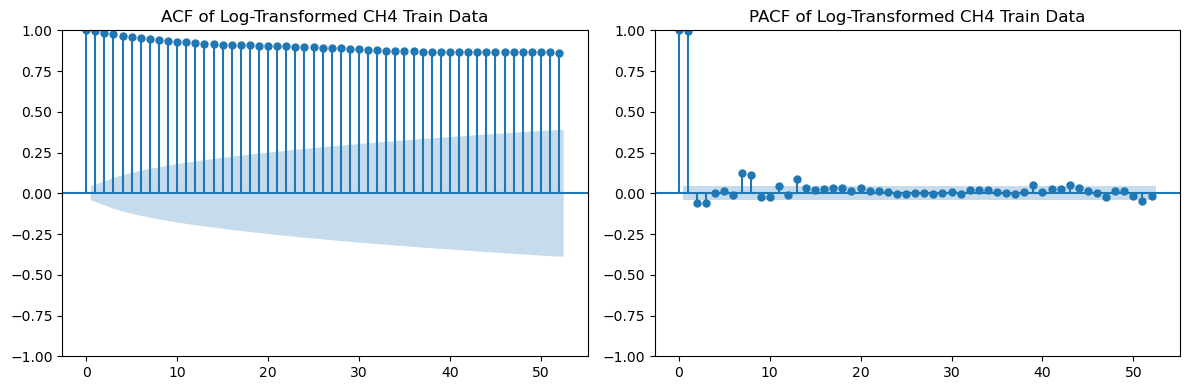


Heteroscedasticity Test for Log-Transformed & Differenced CH4 Train Data
Breusch-Pagan p-value: 0.0384
Heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.0048
Heteroscedasticity detected (White test)

[INFO] Stationarity and Autocorrelation Analysis for Log-Transformed & Differenced CH4 Train Data


C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:94: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


ADF and KPSS tests for Log-Transformed & Differenced CH4 Train Data:
ADF statistic -15.7464
ADF p-value 0.0000
ADF critical values: {'1%': -3.43346628154387, '5%': -2.8629166417427734, '10%': -2.5675028591063254}

KPSS statistic 0.0070
KPSS p-value 0.1000
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the Log-Transformed & Differenced CH4 Train Data time series is likely stationary according to ADF and KPSS tests.



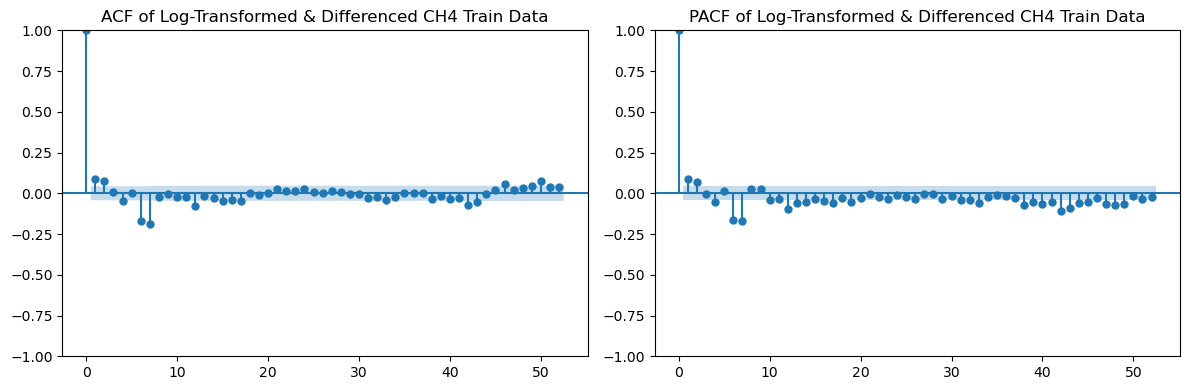


Heteroscedasticity Test for Log-Transformed & Seasonally Differenced CH4 Train Data
Breusch-Pagan p-value: 0.0000
Heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.0000
Heteroscedasticity detected (White test)

[INFO] Stationarity and Autocorrelation Analysis for Log-Transformed & Seasonally Differenced CH4 Train Data
ADF and KPSS tests for Log-Transformed & Seasonally Differenced CH4 Train Data:
ADF statistic -9.8275
ADF p-value 0.0000
ADF critical values: {'1%': -3.4335376782738374, '5%': -2.8629481649631496, '10%': -2.5675196434155123}

KPSS statistic 0.3541
KPSS p-value 0.0969
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the Log-Transformed & Seasonally Differenced CH4 Train Data time series is likely stationary according to ADF and KPSS tests.



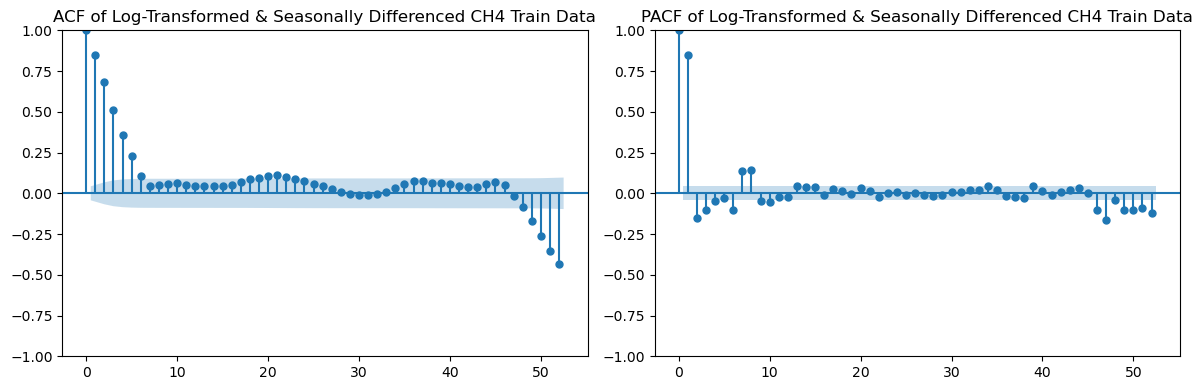


Heteroscedasticity Test for Log-T & Non-Seasonally + Seasonally Diff CH4 Train Data
Breusch-Pagan p-value: 0.0017
Heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.0000
Heteroscedasticity detected (White test)

[INFO] Stationarity and Autocorrelation Analysis for Log-T & Non-Seasonally + Seasonally Diff CH4 Train Data
ADF and KPSS tests for Log-T & Non-Seasonally + Seasonally Diff CH4 Train Data:
ADF statistic -16.9171
ADF p-value 0.0000
ADF critical values: {'1%': -3.4335454666709335, '5%': -2.8629516036655955, '10%': -2.56752147433511}

KPSS statistic 0.0051
KPSS p-value 0.1000
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the Log-T & Non-Seasonally + Seasonally Diff CH4 Train Data time series is likely stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:94: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


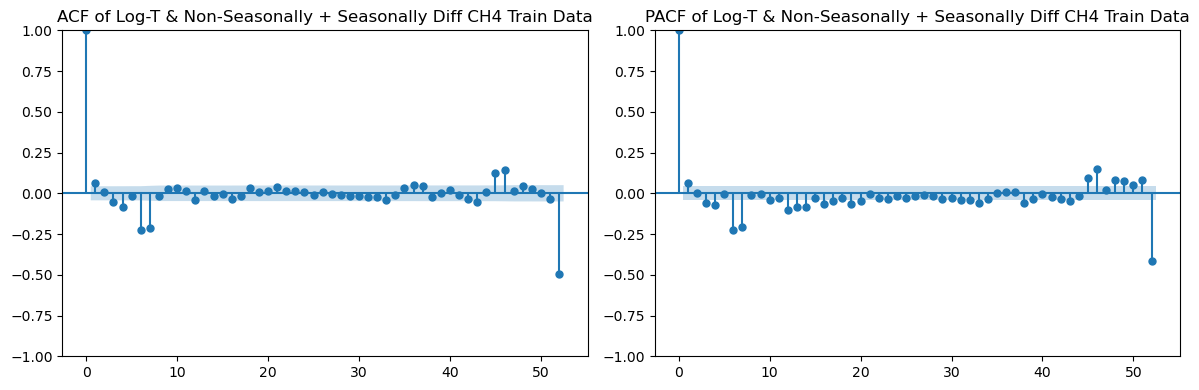

In [20]:
# Test results of log transformation and differening of the training data

# check for heteroscesdasticity & stationarity in the log-transformed data
CH4_train_preprocessor.test_heteroscedasticity(CH4_train_logged, label='Heteroscedasticity Test for Log-Transformed CH4 Train Data')
CH4_train_preprocessor._run_stationarity_and_ac_analysis(CH4_train_logged, label='Log-Transformed CH4 Train Data')

# mean stabilization: differencing the logged data
CH4_train_logged_diff = CH4_train_logged.diff().dropna()

# run stationarity tests on the differenced data 
CH4_train_preprocessor.test_heteroscedasticity(CH4_train_logged_diff, label='Heteroscedasticity Test for Log-Transformed & Differenced CH4 Train Data')
CH4_train_preprocessor._run_stationarity_and_ac_analysis(CH4_train_logged_diff, label='Log-Transformed & Differenced CH4 Train Data')

# seasonal differencing of the logged data
CH4_train_logged_s52diff = CH4_train_logged.diff(52).dropna()

# run heteroscedasticity & stationarity tests on the differenced data 
CH4_train_preprocessor.test_heteroscedasticity(CH4_train_logged_s52diff, label='Heteroscedasticity Test for Log-Transformed & Seasonally Differenced CH4 Train Data')
CH4_train_preprocessor._run_stationarity_and_ac_analysis(CH4_train_logged_s52diff, label='Log-Transformed & Seasonally Differenced CH4 Train Data')

# non-seasonal and seasonal differencing of the logged data
CH4_train_logged_nsdiffs52diff = CH4_train_logged_diff.diff(52).dropna()

# run heteroscedasticity & stationarity tests on the differenced data 
CH4_train_preprocessor.test_heteroscedasticity(CH4_train_logged_nsdiffs52diff, label='Heteroscedasticity Test for Log-T & Non-Seasonally + Seasonally Diff CH4 Train Data')
CH4_train_preprocessor._run_stationarity_and_ac_analysis(CH4_train_logged_nsdiffs52diff, label='Log-T & Non-Seasonally + Seasonally Diff CH4 Train Data')

Log transformation did not stabilize the variance in the CH4 training data.  This may not be an issue since the data range is small vs the absolute magnitude of the values.  The transformation affect needs to be assessed on the model residuals. It's possible that I will need to consider exogenous veriables (SARIMAX), SARIMA with generalized least squares (GLS), or modeling the variance with ARCH/GARCH. 

Importantly, taking the first difference (d=1) and seasonal difference (D=1) did make the data set stationary, so I don't need to test further degrees of differencing.  This will inform the SARIMA model parameters.

From the first non-seasonal difference and seasonal difference (lag = 52), 

- ADF and KPSS indicate that the series is stationary.
- ACF plot: slightly significant spike at lag 1 --> MA(q) = 1 or 2; significant spike at lag 52 suggests a seasonal MA(Q) = 1 (s = 52).
- PACF plot: very similar to the ACF plot with a slightly significant spike at lag 1 --> AR(p) = 1 or 2; also has a significant spike at lag 52, therefore AR(P) = 1.
- summary of SARIMA parameters to start with: (1/2,1,1/2) x (1,1,1)[52]

I will try pmdarima to auto-identify the ARIMA or SARIMA model parameters.

# Auto-ARIMA of the preprocessed CH4 train set series

In [29]:
# search for the best SARIMA model paramaters for the preprocessed, log-transformed CH4 train set with auto-ARIMA
# information criterion = 'aic'

print('Auto_Arima results for Preprocessed, Log-Transformed CH4 Train Data\n')

stepwise_model = auto_arima(
    CH4_train_logged,
    start_p=0, start_q=0,
    max_p=2, max_q=2,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    seasonal=True,
    m=52,                  # weekly data
    d=None,
    D=None,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    information_criterion='aic',
    random_state=42,
    method='lbfgs'
)

print(stepwise_model.summary())

Auto_Arima results for Preprocessed, Log-Transformed CH4 Train Data

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=-17554.208, Time=0.38 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=-17569.276, Time=72.26 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=-17562.863, Time=80.84 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=-17555.319, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=-17569.234, Time=0.52 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=-17577.486, Time=320.74 sec
 ARIMA(1,1,0)(2,0,1)[52] intercept   : AIC=-17580.964, Time=252.35 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=-17575.125, Time=93.99 sec
 ARIMA(1,1,0)(2,0,2)[52] intercept   : AIC=inf, Time=286.09 sec
 ARIMA(1,1,0)(1,0,2)[52] intercept   : AIC=-17575.670, Time=333.91 sec
 ARIMA(0,1,0)(2,0,1)[52] intercept   : AIC=-17572.135, Time=190.17 sec
 ARIMA(2,1,0)(2,0,1)[52] intercept   : AIC=-17583.858, Time=325.60 sec
 ARIMA(2,1,0)(1,0,1)[52] intercept   : AIC=-17579.43

In [30]:
# search for the best SARIMA model paramaters for the CH4 train set with auto-ARIMA
# information criterion = 'bic'

print('Auto_Arima results for Preprocessed, Log-Transformed CH4 Train Data\n')

stepwise_model = auto_arima(
    CH4_train_logged,
    start_p=0, start_q=0,
    max_p=2, max_q=2,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    seasonal=True,
    m=52,                  # weekly data
    d=None,
    D=None,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    information_criterion='bic',
    random_state=42,
    method='lbfgs'
)

print(stepwise_model.summary())

Auto_Arima results for Preprocessed, Log-Transformed CH4 Train Data

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[52] intercept   : BIC=-17542.889, Time=0.50 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : BIC=-17546.639, Time=75.24 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : BIC=-17540.226, Time=81.11 sec
 ARIMA(0,1,0)(0,0,0)[52]             : BIC=-17549.659, Time=0.13 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : BIC=-17538.163, Time=182.83 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : BIC=-17534.256, Time=248.83 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : BIC=-17541.360, Time=27.96 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : BIC=-17552.257, Time=0.57 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : BIC=-17542.146, Time=84.96 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : BIC=-17546.829, Time=102.52 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : BIC=-17555.108, Time=1.27 sec
 ARIMA(2,1,0)(1,0,0)[52] intercept   : BIC=-17548.031, Time=56.28 sec
 ARIMA(2,1,0)(0,0,1)[52] intercept   : BIC=-17542

Interpretation of the results:

AIC favors best fit despite complexity, while BIC penalized complexity more heavily and favors a simpler model.  The AIC and BIC values for both models are close but The AIC score for the first model is the lowest and it has the best log-likelihood score.  Since the data clearly has yearly seasonality, I favor the first model with AIC.  However, I will try fitting SARIMA models with best parameters from both models.  

- AIC: Best model:  ARIMA(2,1,0)(2,0,1)[52]
- BIC: Best model:  ARIMA(2,1,0)(0,0,0)[52] 

# SARIMA models

In [33]:
# model using the auto-ARIMA (AIC) results from the prprocessed log-transformed CH4 train data series  
# AIC: ARIMA(2,1,0)(2,0,1)[52]  

CH4_model = SARIMAX(
    CH4_train_logged, 
    order=(2,1,0), 
    seasonal_order=(2,0,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend='n') # 'n' for no linear trend (drift) term

CH4_model_results1 = CH4_model.fit(method='lbfgs')
print(CH4_model_results1.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  CH4   No. Observations:                 2121
Model:             SARIMAX(2, 1, 0)x(2, 0, [1], 52)   Log Likelihood                9099.762
Date:                              Wed, 04 Jun 2025   AIC                         -18187.524
Time:                                      19:46:24   BIC                         -18153.877
Sample:                                  05-08-1983   HQIC                        -18175.174
                                       - 12-24-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0148      0.016     -0.943      0.346      -0.046       0.016
ar.L2          0.07

In [34]:
# model using the auto-ARIMA (AIC) results from the prprocessed log-transformed CH4 train data series  
# AIC: ARIMA(2,1,1)(2,0,1)[52]  

CH4_model = SARIMAX(
    CH4_train_logged, 
    order=(2,1,1), 
    seasonal_order=(2,0,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend='n' 
    ) 

CH4_model_results2 = CH4_model.fit(method='lbfgs')
print(CH4_model_results2.summary())

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                CH4   No. Observations:                 2121
Model:             SARIMAX(2, 1, 1)x(2, 0, 1, 52)   Log Likelihood                9102.279
Date:                            Wed, 04 Jun 2025   AIC                         -18190.559
Time:                                    20:07:30   BIC                         -18151.303
Sample:                                05-08-1983   HQIC                        -18176.150
                                     - 12-24-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0662      0.362     -0.183      0.855      -0.775       0.642
ar.L2          0.0519      0.021   

In [35]:
# model using the auto-ARIMA (AIC) results from the prprocessed log-transformed CH4 train data series  
# AIC: ARIMA(2,1,0)(1,0,0)[52]  

CH4_model = SARIMAX(
    CH4_train_logged, 
    order=(2,1,0), 
    seasonal_order=(1,0,0,52),
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend='n' 
    ) 

CH4_model_results3 = CH4_model.fit(method='lbfgs')
print(CH4_model_results3.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                CH4   No. Observations:                 2121
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 52)   Log Likelihood                8560.099
Date:                            Wed, 04 Jun 2025   AIC                         -17112.197
Time:                                    21:38:43   BIC                         -17089.664
Sample:                                05-08-1983   HQIC                        -17103.937
                                     - 12-24-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0835      0.009      9.217      0.000       0.066       0.101
ar.L2          0.0707      0.010   

In [36]:
# model using the auto-ARIMA (AIC) results from the prprocessed log-transformed CH4 train data series  
# AIC: ARIMA(2,1,0)(0,0,0)[52]

CH4_model = SARIMAX(
    CH4_train_logged, 
    order=(2,1,0), 
    seasonal_order=(0,0,0,52),
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend='n' 
    ) 

CH4_model_results4 = CH4_model.fit(method='lbfgs')
print(CH4_model_results4.summary())

                               SARIMAX Results                                
Dep. Variable:                    CH4   No. Observations:                 2121
Model:               SARIMAX(2, 1, 0)   Log Likelihood                8783.617
Date:                Wed, 04 Jun 2025   AIC                         -17561.233
Time:                        21:41:21   BIC                         -17544.258
Sample:                    05-08-1983   HQIC                        -17555.018
                         - 12-24-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0835      0.009      9.217      0.000       0.066       0.101
ar.L2          0.0707      0.010      6.968      0.000       0.051       0.091
sigma2      1.463e-05   4.61e-08    317.513      0.0

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
# model using the auto-ARIMA (AIC) results from the prprocessed log-transformed CH4 train data series  
# AIC: ARIMA(2,1,0)(1,0,2)[52]

CH4_model = SARIMAX(
    CH4_train_logged, 
    order=(2,1,0), 
    seasonal_order=(1,0,2,52),
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend='n' 
    ) 

CH4_model_results5 = CH4_model.fit(method='lbfgs')
print(CH4_model_results5.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                     CH4   No. Observations:                 2121
Model:             SARIMAX(2, 1, 0)x(1, 0, [1, 2], 52)   Log Likelihood                9109.379
Date:                                 Wed, 04 Jun 2025   AIC                         -18206.759
Time:                                         21:53:14   BIC                         -18173.109
Sample:                                     05-08-1983   HQIC                        -18194.408
                                          - 12-24-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0460      0.016     -2.913      0.004      -0.077      -0

In [38]:
# model using the auto-ARIMA (AIC) results from the prprocessed log-transformed CH4 train data series  
# AIC: ARIMA(1,1,0)(1,0,1)[52]

CH4_model = SARIMAX(
    CH4_train_logged, 
    order=(1,1,0), 
    seasonal_order=(1,0,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend='n' 
    ) 

CH4_model_results6 = CH4_model.fit(method='lbfgs')
print(CH4_model_results6.summary())

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                  CH4   No. Observations:                 2121
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 52)   Log Likelihood                8625.641
Date:                              Thu, 05 Jun 2025   AIC                         -17243.281
Time:                                      09:49:05   BIC                         -17220.746
Sample:                                  05-08-1983   HQIC                        -17235.020
                                       - 12-24-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0898      0.009      9.498      0.000       0.071       0.108
ar.S.L52       0.53

## Model Residuals Analysis

In [39]:
# extract residuals from the models for analysis 

residuals_CH4_model1 = CH4_model_results1.resid
residuals_CH4_model2 = CH4_model_results2.resid
residuals_CH4_model3 = CH4_model_results3.resid
residuals_CH4_model4 = CH4_model_results4.resid
residuals_CH4_model5 = CH4_model_results5.resid
residuals_CH4_model6 = CH4_model_results6.resid


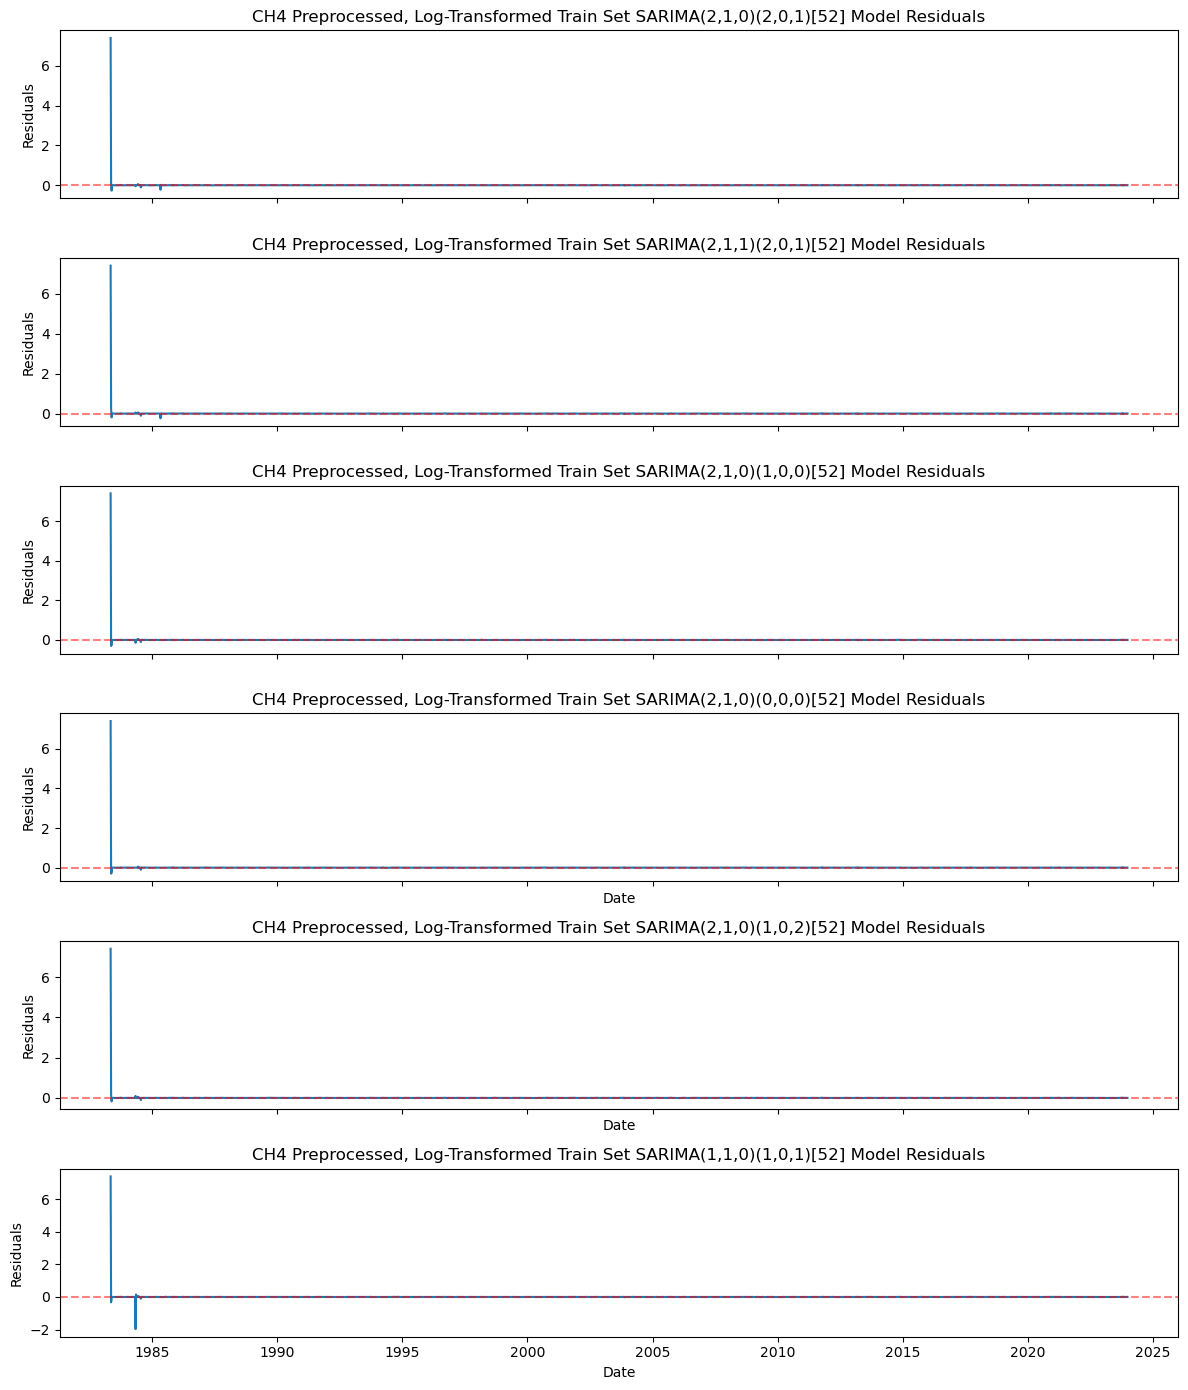

In [40]:
# plot the SARIMA residuals

fig, axs = plt.subplots(6, 1, figsize=(12, 14), sharex=True)

axs[0].plot(residuals_CH4_model1)
axs[0].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,0)(2,0,1)[52] Model Residuals')
axs[0].set_ylabel('Residuals')
axs[0].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[1].plot(residuals_CH4_model2)
axs[1].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,1)(2,0,1)[52] Model Residuals')
axs[1].set_ylabel('Residuals')
axs[1].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[2].plot(residuals_CH4_model3)
axs[2].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,0)(1,0,0)[52] Model Residuals')
axs[2].set_ylabel('Residuals')
axs[2].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[3].plot(residuals_CH4_model4)
axs[3].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,0)(0,0,0)[52] Model Residuals')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Residuals')
axs[3].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[4].plot(residuals_CH4_model5)
axs[4].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,0)(1,0,2)[52] Model Residuals')
axs[4].set_xlabel('Date')
axs[4].set_ylabel('Residuals')
axs[4].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[5].plot(residuals_CH4_model6)
axs[5].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(1,1,0)(1,0,1)[52] Model Residuals')
axs[5].set_xlabel('Date')
axs[5].set_ylabel('Residuals')
axs[5].axhline(0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

- Mostly constant variance, centered around 0 from ~ 1985 on. So, the residuals appear to be homoscedastic.
- the large spike at the very beginning is most likely an artifact of the SARIMAX model warm up. This conclusion is based on a test in which the first two years (1983-1984) were trimmed after fitting it to the GasPreprocessor class.  The series was fit to a SARIMAX model exactly as above.  The plot of the residuals showed a large spike, very similar in magnitude at the beginning of the series, which was 1985-01-01.  As seen in the residual plot above, of the full series, there is no spike at 1985-01-01.  
- since I have a substantial amount of data in the train set, I will trim the first 2 years of data residuals for further analysis.   

In [41]:
# trim the first 104 (2 years) residuals to remove early spike

CH4_sarimax_trimmedresids1 = residuals_CH4_model1[105:]
CH4_sarimax_trimmedresids2 = residuals_CH4_model2[105:]
CH4_sarimax_trimmedresids3 = residuals_CH4_model3[105:]
CH4_sarimax_trimmedresids4 = residuals_CH4_model4[105:]
CH4_sarimax_trimmedresids5 = residuals_CH4_model5[105:]
CH4_sarimax_trimmedresids6 = residuals_CH4_model6[105:]


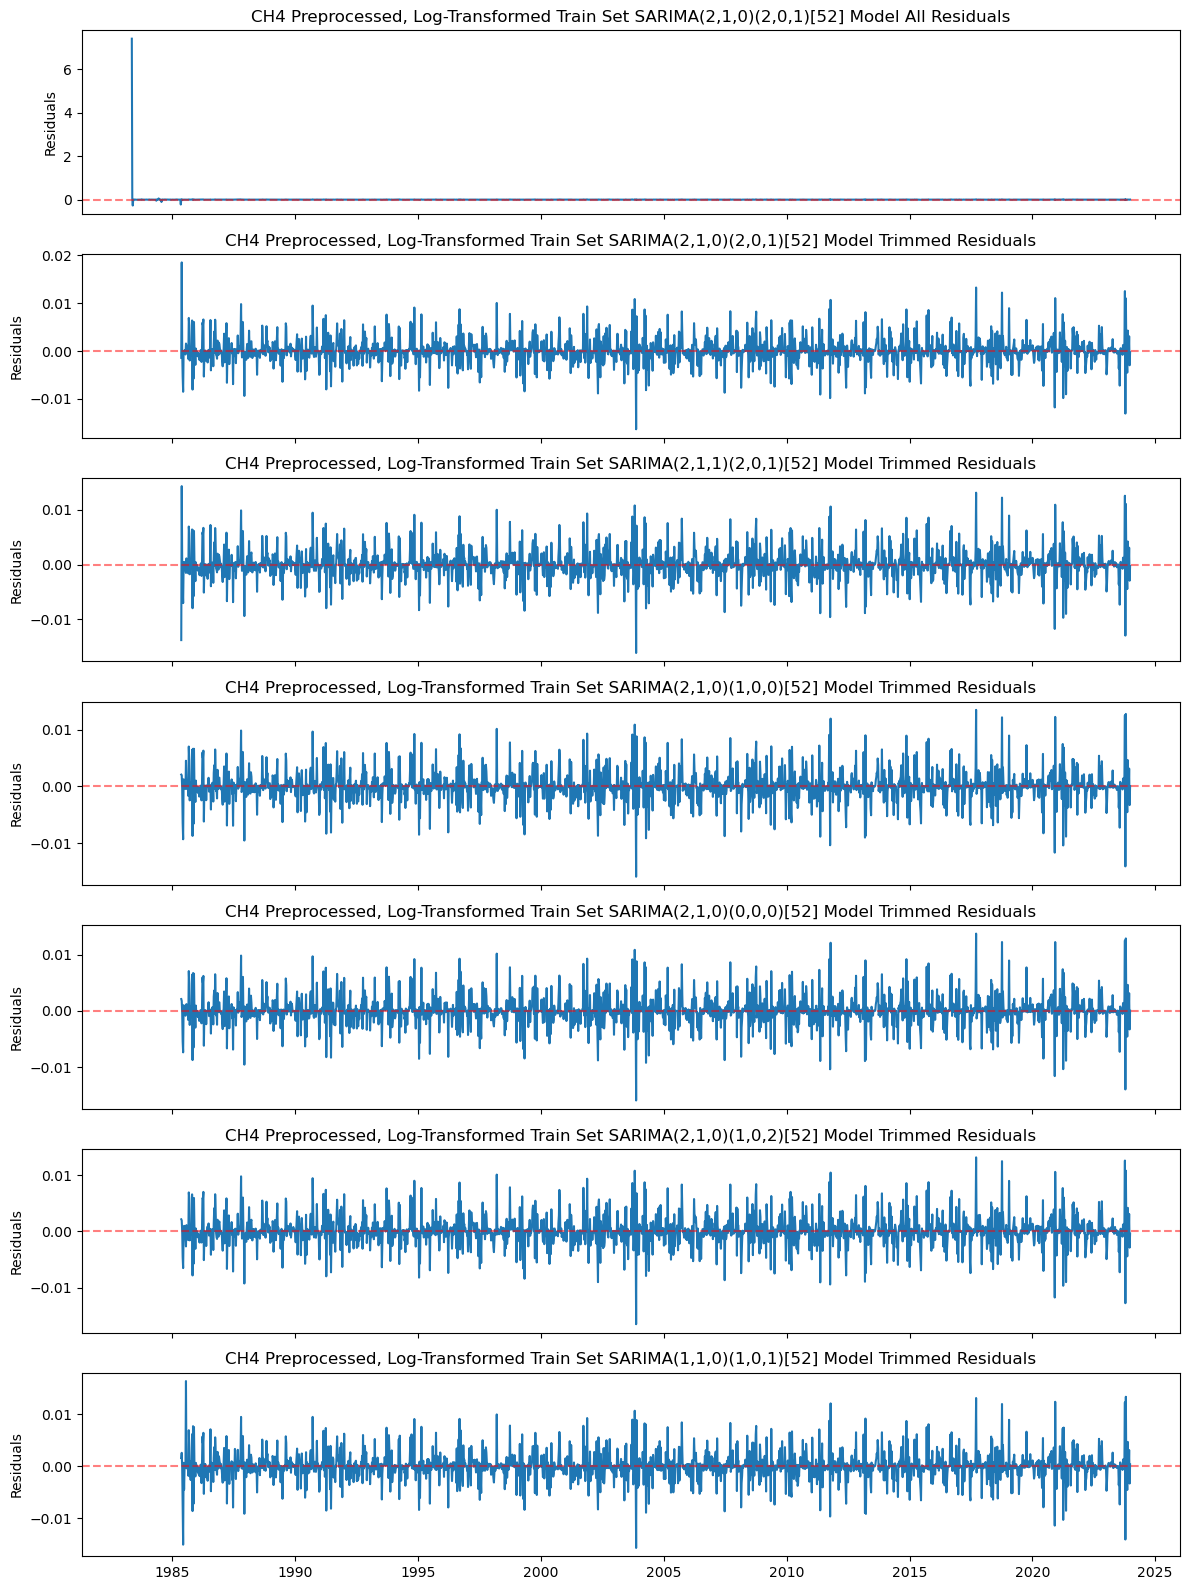

In [42]:
# plot the trimmed SARIMA residuals

fig, axs = plt.subplots(7, 1, figsize=(12, 16), sharex=True)

axs[0].plot(residuals_CH4_model1)
axs[0].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,0)(2,0,1)[52] Model All Residuals')
axs[0].set_ylabel('Residuals')
axs[0].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[1].plot(CH4_sarimax_trimmedresids1)
axs[1].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,0)(2,0,1)[52] Model Trimmed Residuals')
axs[1].set_ylabel('Residuals')
axs[1].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[2].plot(CH4_sarimax_trimmedresids2)
axs[2].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,1)(2,0,1)[52] Model Trimmed Residuals')
axs[2].set_ylabel('Residuals')
axs[2].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[3].plot(CH4_sarimax_trimmedresids3)
axs[3].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,0)(1,0,0)[52] Model Trimmed Residuals')
axs[3].set_ylabel('Residuals')
axs[3].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[4].plot(CH4_sarimax_trimmedresids4)
axs[4].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,0)(0,0,0)[52] Model Trimmed Residuals')
axs[4].set_ylabel('Residuals')
axs[4].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[5].plot(CH4_sarimax_trimmedresids5)
axs[5].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(2,1,0)(1,0,2)[52] Model Trimmed Residuals')
axs[5].set_ylabel('Residuals')
axs[5].axhline(0, color='red', linestyle='--', alpha=0.5)

axs[6].plot(CH4_sarimax_trimmedresids6)
axs[6].set_title('CH4 Preprocessed, Log-Transformed Train Set SARIMA(1,1,0)(1,0,1)[52] Model Trimmed Residuals')
axs[6].set_ylabel('Residuals')
axs[6].axhline(0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

The initial spike seen in the first panel (all residuals) is likely due to start up instability, which is why I also plotted the trimmed residuals.  Overall, the inital spikes are not too concerning since the rest of the residuals are behaving normally.

According to ChatGPT and Deepseek, the residuals of models 1 & 2 (trimmed residuals) are most like white noise, with no obvious trend, drift or changing variance.  Models 3 and 4 have more "clear" signs of variance instability.  

I will examine distribution, autocorrelation via the Ljung-Box test, heteroscedasticity test results, and AIC/BIC scores to decide on a model to move forward with.  

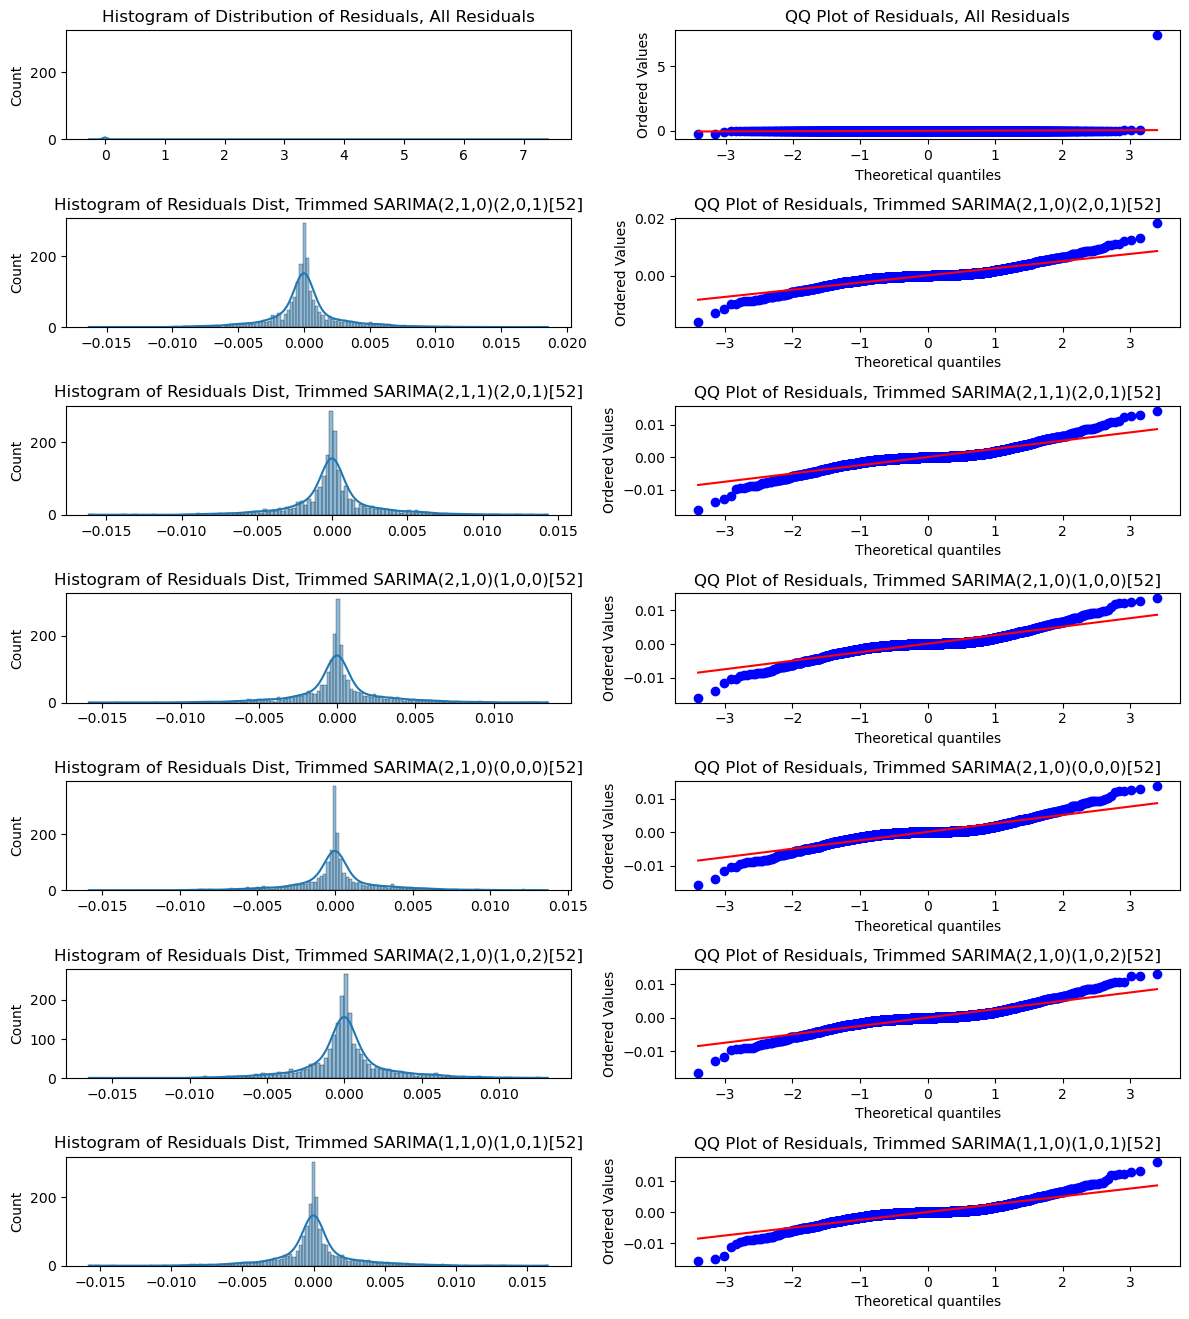

In [52]:
# check residuals for normality

# Histograms
plt.figure(figsize=(12,26))

plt.subplot(14,2,1)
sns.histplot(residuals_CH4_model1, kde=True)
plt.title('Histogram of Distribution of Residuals, All Residuals')

plt.subplot(14,2,3)
sns.histplot(CH4_sarimax_trimmedresids1, kde=True)
plt.title('Histogram of Residuals Dist, Trimmed SARIMA(2,1,0)(2,0,1)[52]')

plt.subplot(14,2,5)
sns.histplot(CH4_sarimax_trimmedresids2, kde=True)
plt.title('Histogram of Residuals Dist, Trimmed SARIMA(2,1,1)(2,0,1)[52]')

plt.subplot(14,2,7)
sns.histplot(CH4_sarimax_trimmedresids3, kde=True)
plt.title('Histogram of Residuals Dist, Trimmed SARIMA(2,1,0)(1,0,0)[52]')

plt.subplot(14,2,9)
sns.histplot(CH4_sarimax_trimmedresids4, kde=True)
plt.title('Histogram of Residuals Dist, Trimmed SARIMA(2,1,0)(0,0,0)[52]')

plt.subplot(14,2,11)
sns.histplot(CH4_sarimax_trimmedresids5, kde=True)
plt.title('Histogram of Residuals Dist, Trimmed SARIMA(2,1,0)(1,0,2)[52]')

plt.subplot(14,2,13)
sns.histplot(CH4_sarimax_trimmedresids6, kde=True)
plt.title('Histogram of Residuals Dist, Trimmed SARIMA(1,1,0)(1,0,1)[52]')

# QQ Plots
plt.subplot(14,2,2)
stats.probplot(residuals_CH4_model1, dist='norm', plot=plt)
plt.title('QQ Plot of Residuals, All Residuals')

plt.subplot(14,2,4)
stats.probplot(CH4_sarimax_trimmedresids1, dist='norm', plot=plt)
plt.title('QQ Plot of Residuals, Trimmed SARIMA(2,1,0)(2,0,1)[52]')

plt.subplot(14,2,6)
stats.probplot(CH4_sarimax_trimmedresids2, dist='norm', plot=plt)
plt.title('QQ Plot of Residuals, Trimmed SARIMA(2,1,1)(2,0,1)[52]')

plt.subplot(14,2,8)
stats.probplot(CH4_sarimax_trimmedresids3, dist='norm', plot=plt)
plt.title('QQ Plot of Residuals, Trimmed SARIMA(2,1,0)(1,0,0)[52]')

plt.subplot(14,2,10)
stats.probplot(CH4_sarimax_trimmedresids4, dist='norm', plot=plt)
plt.title('QQ Plot of Residuals, Trimmed SARIMA(2,1,0)(0,0,0)[52]')

plt.subplot(14,2,12)
stats.probplot(CH4_sarimax_trimmedresids5, dist='norm', plot=plt)
plt.title('QQ Plot of Residuals, Trimmed SARIMA(2,1,0)(1,0,2)[52]')

plt.subplot(14,2,14)
stats.probplot(CH4_sarimax_trimmedresids6, dist='norm', plot=plt)
plt.title('QQ Plot of Residuals, Trimmed SARIMA(1,1,0)(1,0,1)[52]')

plt.tight_layout()
plt.show()

The trimmed residuals have a much more normal distribution according to the histograms.  The QQ plots show that the mean and median are approximately normal (middle points, close to x axis = 0 fall on the red line). All models show a good, symmetric distribution of residuals.  Models 1 and 2 ((2,1,0)(2,0,1)[52], (2,1,1)(2,0,1)[52]) have a slight edge based on the QQ plots since the ordered values follow the red line more extensively compared to models 3 and 4 that show more deviation at the tails.  

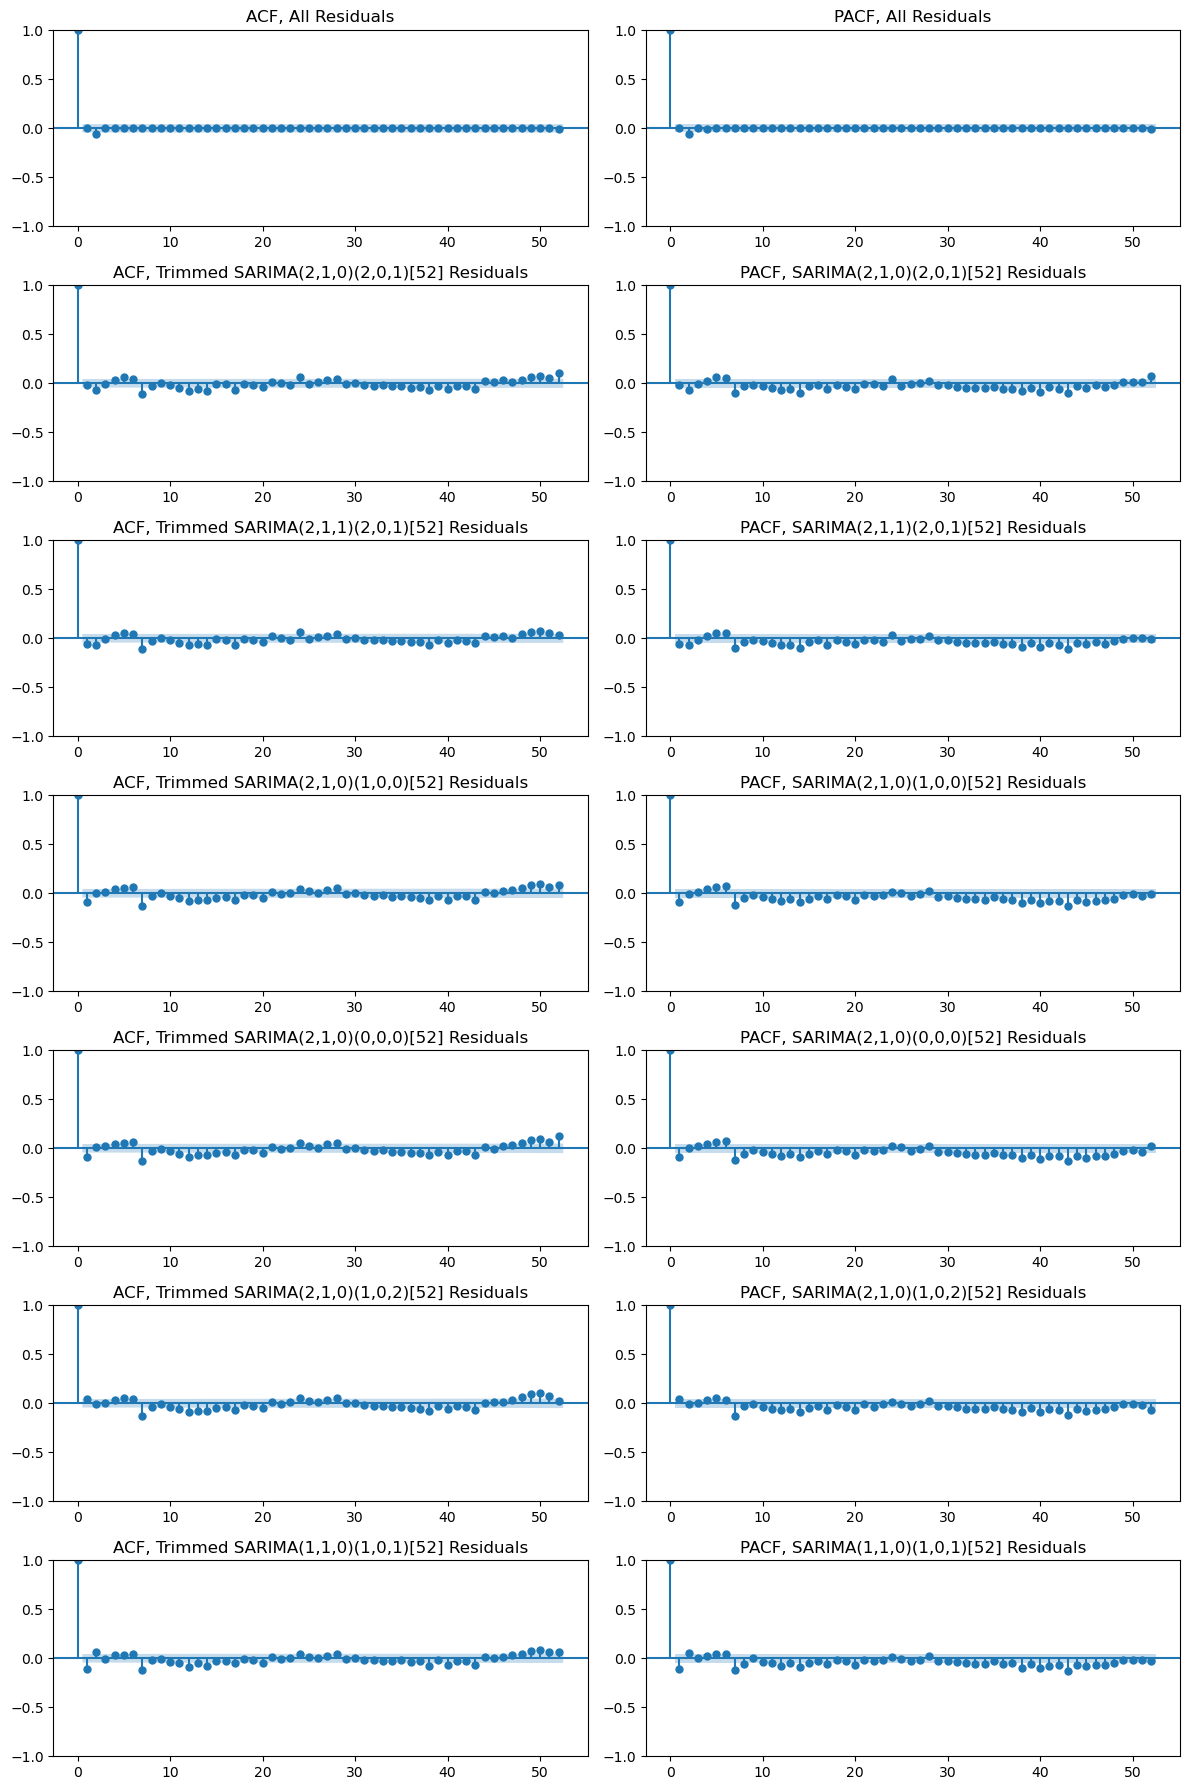

In [61]:
# Check autocorrelation of SARIMA model residuals

fig, axs = plt.subplots(7,2,figsize=(12,18))

plot_acf(residuals_CH4_model1, lags=52, ax=axs[0,0])
axs[0,0].set_title('ACF, All Residuals')

plot_pacf(residuals_CH4_model1, lags=52, ax=axs[0,1])
axs[0,1].set_title('PACF, All Residuals')

plot_acf(CH4_sarimax_trimmedresids1, lags=52, ax=axs[1,0])
axs[1,0].set_title('ACF, Trimmed SARIMA(2,1,0)(2,0,1)[52] Residuals')

plot_pacf(CH4_sarimax_trimmedresids1, lags=52, ax=axs[1,1])
axs[1,1].set_title('PACF, SARIMA(2,1,0)(2,0,1)[52] Residuals')

plot_acf(CH4_sarimax_trimmedresids2, lags=52, ax=axs[2,0])
axs[2,0].set_title('ACF, Trimmed SARIMA(2,1,1)(2,0,1)[52] Residuals')

plot_pacf(CH4_sarimax_trimmedresids2, lags=52, ax=axs[2,1])
axs[2,1].set_title('PACF, SARIMA(2,1,1)(2,0,1)[52] Residuals')

plot_acf(CH4_sarimax_trimmedresids3, lags=52, ax=axs[3,0])
axs[3,0].set_title('ACF, Trimmed SARIMA(2,1,0)(1,0,0)[52] Residuals')

plot_pacf(CH4_sarimax_trimmedresids3, lags=52, ax=axs[3,1])
axs[3,1].set_title('PACF, SARIMA(2,1,0)(1,0,0)[52] Residuals')

plot_acf(CH4_sarimax_trimmedresids4, lags=52, ax=axs[4,0])
axs[4,0].set_title('ACF, Trimmed SARIMA(2,1,0)(0,0,0)[52] Residuals')

plot_pacf(CH4_sarimax_trimmedresids4, lags=52, ax=axs[4,1])
axs[4,1].set_title('PACF, SARIMA(2,1,0)(0,0,0)[52] Residuals')

plot_acf(CH4_sarimax_trimmedresids5, lags=52, ax=axs[5,0])
axs[5,0].set_title('ACF, Trimmed SARIMA(2,1,0)(1,0,2)[52] Residuals')

plot_pacf(CH4_sarimax_trimmedresids5, lags=52, ax=axs[5,1])
axs[5,1].set_title('PACF, SARIMA(2,1,0)(1,0,2)[52] Residuals')

plot_acf(CH4_sarimax_trimmedresids6, lags=52, ax=axs[6,0])
axs[6,0].set_title('ACF, Trimmed SARIMA(1,1,0)(1,0,1)[52] Residuals')

plot_pacf(CH4_sarimax_trimmedresids6, lags=52, ax=axs[6,1])
axs[6,1].set_title('PACF, SARIMA(1,1,0)(1,0,1)[52] Residuals')

plt.tight_layout()
plt.show()

Model 2 (ARIMA(2,1,1)(2,0,1)[52]) has the tightest lags, especially around lag 52.  

In [49]:
# Run Ljung-Box test on the residuals of the SARIMA models to help interpret the
# ACF and PACF plots 

models = {
    'SARIMA(2,1,0)(2,0,1)[52]': residuals_CH4_model1,
    'SARIMA(2,1,1)(2,0,1)[52]': residuals_CH4_model2,
    'SARIMA(2,1,0)(1,0,0)[52]': residuals_CH4_model3,
    'SARIMA(2,1,0)(0,0,0)[52]': residuals_CH4_model4,
    'SARIMA(2,1,0)(1,0,2)[52]': residuals_CH4_model5,
    'SARIMA(1,1,0)(1,0,1)[52]': residuals_CH4_model6,
}

for name, resid in models.items():
    print(f'\nLjung-Box test for {name}') 
    result = acorr_ljungbox(resid, lags=[7,13,26,52], return_df=True)
    print(result[['lb_stat', 'lb_pvalue']])


Ljung-Box test for SARIMA(2,1,0)(2,0,1)[52]
     lb_stat  lb_pvalue
7   2.975452   0.887264
13  2.977423   0.998014
26  2.986011   1.000000
52  3.083250   1.000000

Ljung-Box test for SARIMA(2,1,1)(2,0,1)[52]
     lb_stat  lb_pvalue
7   3.687365   0.815000
13  3.688901   0.994073
26  3.697578   1.000000
52  3.816566   1.000000

Ljung-Box test for SARIMA(2,1,0)(1,0,0)[52]
     lb_stat  lb_pvalue
7   5.970740   0.543170
13  5.973152   0.947125
26  5.981339   0.999984
52  6.791468   1.000000

Ljung-Box test for SARIMA(2,1,0)(0,0,0)[52]
     lb_stat  lb_pvalue
7   5.970401   0.543210
13  5.972125   0.947162
26  5.980257   0.999984
52  5.986740   1.000000

Ljung-Box test for SARIMA(2,1,0)(1,0,2)[52]
     lb_stat  lb_pvalue
7   2.270632   0.943357
13  2.272042   0.999538
26  2.280225   1.000000
52  2.682354   1.000000

Ljung-Box test for SARIMA(1,1,0)(1,0,1)[52]
       lb_stat     lb_pvalue
7     4.641154  7.036601e-01
13    4.678359  9.816083e-01
26    4.688427  9.999988e-01
52  139.914613

All models except for model 6(SARIMA(1,1,0)(1,0,1)[52]) fail to reject the H0 hypothesis of no autocorrelation at all lags.  Lag 52 of model 6 is statistically significant, suggesting that this model performs the worst for capturing all seasonal structure.  

In [53]:
# check for heteroscesdasticity in the log-transformed data with trimmed residuals

print('Heteroscedasticity Tests for CH4 Train Set Model Residuals\n')

print('Model 1: SARIMA(2,1,0)(2,0,1)[52]')
CH4_train_preprocessor.test_heteroscedasticity(residuals_CH4_model1, label='All Residuals')
CH4_train_preprocessor.test_heteroscedasticity(CH4_sarimax_trimmedresids1, label='Trimmed Residuals')

print('\nModel 2: SARIMA(2,1,1)(2,0,1)[52]')
CH4_train_preprocessor.test_heteroscedasticity(residuals_CH4_model2, label='All Residuals')
CH4_train_preprocessor.test_heteroscedasticity(CH4_sarimax_trimmedresids2, label='Trimmed Residuals')

print('\nModel 3: SARIMA(2,1,0)(1,0,0)[52]')
CH4_train_preprocessor.test_heteroscedasticity(residuals_CH4_model3, label='All Residuals')
CH4_train_preprocessor.test_heteroscedasticity(CH4_sarimax_trimmedresids3, label='Trimmed Residuals')

print('\nModel 4: SARIMA(2,1,0)(0,0,0)[52]')
CH4_train_preprocessor.test_heteroscedasticity(residuals_CH4_model4, label='All Residuals')
CH4_train_preprocessor.test_heteroscedasticity(CH4_sarimax_trimmedresids4, label='Trimmed Residuals')

print('\nModel 5: SARIMA(2,1,0)(1,0,2)[52]')
CH4_train_preprocessor.test_heteroscedasticity(residuals_CH4_model5, label='All Residuals')
CH4_train_preprocessor.test_heteroscedasticity(CH4_sarimax_trimmedresids5, label='Trimmed Residuals')

print('\nModel 6: SARIMA(1,1,0)(1,0,1)[52]')
CH4_train_preprocessor.test_heteroscedasticity(residuals_CH4_model6, label='All Residuals')
CH4_train_preprocessor.test_heteroscedasticity(CH4_sarimax_trimmedresids6, label='Trimmed Residuals')

Heteroscedasticity Tests for CH4 Train Set Model Residuals

Model 1: SARIMA(2,1,0)(2,0,1)[52]

All Residuals
Breusch-Pagan p-value: 0.0826
No heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.0181
Heteroscedasticity detected (White test)

Trimmed Residuals
Breusch-Pagan p-value: 0.5449
No heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.2954
No heteroscedasticity detected (White test)

Model 2: SARIMA(2,1,1)(2,0,1)[52]

All Residuals
Breusch-Pagan p-value: 0.0824
No heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.0180
Heteroscedasticity detected (White test)

Trimmed Residuals
Breusch-Pagan p-value: 0.5859
No heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.2368
No heteroscedasticity detected (White test)

Model 3: SARIMA(2,1,0)(1,0,0)[52]

All Residuals
Breusch-Pagan p-value: 0.0822
No heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.0179
Heteroscedasticity detected (Whit

{'bp_pvalue': 0.6903008367786996, 'white_pvalue': 0.09062230194049677}

The Breusch-Pagan test results indicate that heteroscedasticity was not detected in the residuals of all models, trimmed and untrimmed. Importantly both Breusch-Pagan and White tests are negative for heteroscedasticity for the trimmed residuals of models 3, 4, and 5.  

### Model Performance Metrics  
(from respective model summaries)

**Optimization Method**: L-BFGS  

```text
Model 1: ARIMA(2,1,0)(2,0,1)[52]  
    AIC: -18144.344 | BIC: -18110.694  

Model 2: ARIMA(2,1,1)(2,0,1)[52]  
    AIC: -18180.986 | BIC: -18141.728  

Model 3: ARIMA(2,1,0)(1,0,0)[52]  
    AIC: -17122.350 | BIC: -17099.815  

Model 4: ARIMA(2,1,0)(0,0,0)[52]  
    AIC: -17571.405 | BIC: -17554.429  

MODEL 5: SARIMA(2,1,0)(1,0,2)[52]  **BEST**
    AIC: -18211.695 | BIC: -18178.040  

Model 6: SARIMA(1,1,0)(1,0,1)[52]  
    AIC: -17253.441 | BIC: -17230.904  
```

### Legend  
- **AIC**: Lower = Better (penalizes complexity)  
- **BIC**: Lower = Better (stronger penalty than AIC)  

**Best Model**: model 5 SARIMA(2,1,0)(1,0,2)[52]
- Model 5 has significantly lower AIC and BIC scores.  Its AIC score is 31 points lower than the model with the next lowest AIC score, and a BIC score that is 37 points lower.  A difference > 10 is considered substantial.
- Models 3, 4, and 6 have the highest AIC and BIC scores.
- Model 5, along with models 1-4 reject the Ljung_Box test H0 hypothesis for autocorrelation at all tested lags.  Model 6 failed to reject the H0 hypothesis at lag 52. So model 6 is ruled out in this grouping.
-  All models show no heteroscedasticity in trimmed residuals.
-  The QQ plot of model 5 appears to hug the red line at the tails more than other models.
-  Model 5 is simpler, uses fewer parameters, than models 1 and 2.

# Save Best Model Parameters for Production

In [71]:
import json
from datetime import datetime

model_config = {
    'model_type': 'SARIMAX',
    'order': (2,1,0),
    'seasonal_order': (1,0,2,52),
    'trend': 'n',
    'enforce_stationarity': False,
    'envorce_invertibility': False,
    'training_data_range': {
        'start': CH4_train_logged.index[0].strftime('%Y-%m-%d'),
        'end': CH4_train_logged.index[-1].strftime('%Y-%m-%d')
    },
    'fit_method': 'lbfgs',
    'saved_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
}

# save as JSON file
with open('../results/CH4_train_best_model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

print('CH4 train set model configuration saved.  Re-fit in next notebook.')

CH4 train set model configuration saved.  Re-fit in next notebook.


# Save Logged Data for use in Forecasting

In [69]:
# define path
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True, parents=True)

# save the logged CH4 train data
CH4_train_logged.to_csv(
    output_dir / 'ch4_train_logged.csv', 
    index=True, # keep the datetime index
    header=['log_ch4_ppb'],
    float_format='%.5f'
)

print(f'Saved to: {output_dir / "ch4_train_logged.csv"}')

Saved to: ..\data\processed\ch4_train_logged.csv


In [70]:
# save the logged CH4 test data
CH4_test_logged.to_csv(
    output_dir / 'ch4_test_logged.csv', 
    index=True, # keep the datetime index
    header=['log_ch4_ppb'],
    float_format='%.5f'
)

print(f'Saved to: {output_dir / "ch4_test_logged.csv"}')

Saved to: ..\data\processed\ch4_test_logged.csv
